In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
import openpyxl

# libraries for data manipulation and model building
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor  # used for imputing missing values
from sklearn.model_selection import KFold,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

# from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import OneHotEncoder


# import warnings
# import pandas_access as mdb
# warnings.filterwarnings('ignore')
# %matplotlib inline

This project features the 2023 national data of the YouthRisk Behavior Surveillance System (YRBSS) survey conducted by the Centers for Disease Control and Prevention (CDC). It is developed in 1990 to monitor health risk behaviors among high school students in the United States and has provided insights into the leading causes of death, disability, and social problems among adolescents. Alongside with the student demographics (sex, sexual identity, race and ethnicity, and grade), a total of 107 survey questions includes youth health behaviors and conditions, substance use behaviors, and student experiences. \
The goal of this initial EDA is to understand the dataset and the patterns as well as the possible co-occurence of health risk behaviors. \
Apart from two free text entry variables recording the respondent's height in meters (q6) and weight in kilograms (q7) that are also used to calculate the Bosy Mass Index (BMI) in the formula: BMI = Weight/Height^2, most of the survey questions require respondents to select from categorized choices defining the extent of the described situation in the question. There are 20103 entries collected for 2023. More on data edits and the detailed code book can be found in the User Guide for 2023 YRBS. \
Changes to note from the 2021 national dataset is that substance use weighted percentage has not change significantly (by 0.03%) within the 2 years, mental health related problems have been alleviated by a small scale as we can see that the rate of respondents that have seriously considered attempting suicide decreased from 22.2% to 20.4%. We will continue to investigate the changes between survey result distributions implement this project. \
The national dataset does not have state nor region identifiers because the national samples are not constructed to provide representative data at state or region levels.

In [3]:
file_path = "/content/drive/MyDrive/yrbss/XXHq_20223.xlsx"

# Read the Excel file
df = pd.read_excel(file_path, engine="openpyxl")
df.drop(columns = ['orig_rec'], inplace = True)

In [4]:
# Drop columns Q88 to Q107 for not being in standard survey and too much missing values which may not contribute to the project
columns_to_drop = [f"q{num}" for num in range(88, 108)]  # Generates a list of q88 to q107
df = df.drop(columns=columns_to_drop, errors='ignore')  # Ignore errors if column doesn't exist

In [5]:
# Drop columns "q6orig" and "q7orig" for we have the calculated response stored for q6 and q7, so we no longer need the original record.
# Drop not meaningful column "site" as it originally represents the geographic location of the school or district where the survey data is collected, but was masked from the national data sample.
df = df.drop(columns=["q6orig", "q7orig", "site"], errors='ignore')

In [6]:
print(df.head())

   raceeth  record   q1   q2   q3   q4     q5    q6     q7   q8  ...  q82  \
0      NaN       1  3.0  1.0  1.0  NaN      C  1.65  81.65  4.0  ...  2.0   
1      5.0       2  4.0  2.0  1.0  2.0      E   NaN    NaN  5.0  ...  2.0   
2      5.0       3  5.0  2.0  3.0  2.0      E  1.68  74.84  5.0  ...  2.0   
3      5.0       4  6.0  1.0  2.0  2.0      E   NaN    NaN  4.0  ...  2.0   
4      5.0       5  3.0  2.0  1.0  2.0      E  1.85  56.70  5.0  ...  2.0   

   q83  q84  q85  q86  q87     BMIPCT  weight  stratum    psu  
0  1.0  1.0  3.0  1.0  NaN  97.083855  0.8614      103  16294  
1  2.0  3.0  5.0  1.0  4.0        NaN  0.8920      103  16294  
2  1.0  2.0  1.0  1.0  3.0  92.262516  0.5081      103  16294  
3  1.0  3.0  4.0  1.0  3.0        NaN  1.1759      103  16294  
4  1.0  3.0  3.0  1.0  4.0   7.567053  0.8920      103  16294  

[5 rows x 93 columns]


In [7]:
print(df.columns.tolist())
print(df.info())

['raceeth', 'record', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14', 'q15', 'q16', 'q17', 'q18', 'q19', 'q20', 'q21', 'q22', 'q23', 'q24', 'q25', 'q26', 'q27', 'q28', 'q29', 'q30', 'q31', 'q32', 'q33', 'q34', 'q35', 'q36', 'q37', 'q38', 'q39', 'q40', 'q41', 'q42', 'q43', 'q44', 'q45', 'q46', 'q47', 'q48', 'q49', 'q50', 'q51', 'q52', 'q53', 'q54', 'q55', 'q56', 'q57', 'q58', 'q59', 'q60', 'q61', 'q62', 'q63', 'q64', 'q65', 'q66', 'q67', 'q68', 'q69', 'q70', 'q71', 'q72', 'q73', 'q74', 'q75', 'q76', 'q77', 'q78', 'q79', 'q80', 'q81', 'q82', 'q83', 'q84', 'q85', 'q86', 'q87', 'BMIPCT', 'weight', 'stratum', 'psu']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20103 entries, 0 to 20102
Data columns (total 93 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   raceeth  19733 non-null  float64
 1   record   20103 non-null  int64  
 2   q1       20005 non-null  float64
 3   q2       19945 non-null  float64
 4 

In [8]:
print(df.describe())

            raceeth        record            q1            q2            q3  \
count  19733.000000  20103.000000  20005.000000  19945.000000  19910.000000   
mean       5.010845  10140.386161      4.892677      1.504437      2.361477   
std        1.832258   5863.836462      1.218455      0.499993      1.101724   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        5.000000   5062.500000      4.000000      1.000000      1.000000   
50%        5.000000  10129.000000      5.000000      2.000000      2.000000   
75%        6.000000  15203.500000      6.000000      2.000000      3.000000   
max        8.000000  20386.000000      7.000000      2.000000      5.000000   

                 q4            q6            q7            q8            q9  \
count  19849.000000  17814.000000  17814.000000  15071.000000  19598.000000   
mean       1.798630      1.696357     68.680140      4.310796      1.324625   
std        0.401034      0.102717     18.466386    

In [9]:
# missing values
missing_counts_df = df.isnull().sum()
missing_percent_df = df.isnull().mean()
missing_df = pd.DataFrame({'missing_counts': missing_counts_df,
                              'missing_percent': missing_percent_df}).sort_values(
    by='missing_percent', ascending=False)
missing_df[missing_df['missing_percent'] > 0.3]

,missing_counts,missing_percent
q13,8729,0.434214
q16,8451,0.420385
q66,8308,0.413272
q34,7946,0.395264
q82,7325,0.364373
q78,7139,0.355121
q77,6227,0.309755
q37,6178,0.307317
q67,6167,0.306770


Questions with the highest missing percentages (>30%) are:
\
Q13 - During the past 12 months, on how many days did you carry a gun?\
Q16 - During the past 12 months, how many times were you in a physical fight?\
Q66 - How do you describe your weight?\
Q34 - During the past 30 days, on the days you smoked, how many cigarettes did you smoke per day?\
Q82 - During the past 12 months, have you been tested for a sexuality transmitted disease (STD) other than HIV, such as chlamydia or gonorrhea?\
Q78 - During the past 12 months, on how many sports teams did you play?\
Q77 - In an average week when you are in school on how many days do you go to physical education (PE) classes?\
Q37 - During the past 30 days, how did you usually get your electronic vapor?\
Q67 - Which of the following are you trying to do about your weight?

q4     1
q35    1
q31    1
q26    1
q24    1
q25    1
q19    1
q18    1
q56    1
dtype: int64

In [10]:
# unique value counts
cols_to_drop = df.nunique().sort_values()[df.nunique().sort_values() == 1]
cols_to_drop

,0


In [11]:
# Define response mappings
response_mappings = {
    "q1": {1: 12, 2: 13, 3: 14, 4: 15, 5: 16, 6: 17, 7: 18},
    "q2": {1: 0, 2: 1},
    "q3": {1: 9, 2: 10, 3: 11, 4: 12, 5: 13}, ## E.Ungraded or other grade is represented by 13
    "q4": {1: 1, 2: 0},
    "q8": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}, ## seat belt use, starts from 0=never, to 4=always
    "q9": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q10": {1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}, # binned, 0=did not drive, 1=not drunk driving, 2=drunk drove at least once
    "q11": {1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2, 7: 3, 8: 3}, # binned, 0=did not drive, 1=not text driving, 2=texted 1-20 days, 3=over 20 days
    "q12": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q13": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q14": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q15": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6.5, 6: 8.5, 7: 10.5, 8: 12},
    "q16": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6.5, 6: 8.5, 7: 10.5, 8: 12},
    "q17": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6.5, 6: 8.5, 7: 10.5, 8: 12},
    "q18": {1: 1, 2: 0},
    "q19": {1: 1, 2: 0},
    "q20": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q21": {1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}, # binned, 0=did not date, 1=0 time, 2=at least once
    "q22": {1: 0, 2: 1, 3: 2, 4: 2, 5: 2, 6: 2}, # binned, 0=did not date, 1=0 time, 2=at least once
    "q23": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},
    "q24": {1: 1, 2: 0},
    "q25": {1: 1, 2: 0},
    "q26": {1: 1, 2: 0},
    "q27": {1: 1, 2: 0},
    "q28": {1: 1, 2: 0},
    "q29": {1: 0, 2: 1, 3: 2.5, 4: 4.5, 5: 6},
    "q30": {1: 2, 2: 1, 3: 0}, # ever injured in suicide, 2=did not attempt, 1=yes, 0=no
    "q31": {1: 1, 2: 0},  # Ever smoked a cigarette (Yes=1, No=0)
    "q32": {1: 0, 2: 8, 3: 9.5, 4: 11.5, 5: 13.5, 6: 15.5, 7: 17},  # 0=never smoked, Age of first cigarette use (average age for range)
    "q33": {1: 0, 2: 1.5, 3: 3.5, 4: 7.5, 5: 14.5, 6: 24.5, 7: 30},  # Days smoked cigarettes in the past 30 days
    "q34": {1: 0, 2: 0.5, 3: 1, 4: 3.5, 5: 8, 6: 15.5, 7: 20},
    "q35": {1: 1, 2: 0},  # Ever used electronic vapor products (Yes=1, No=0)
    "q36": {1: 0, 2: 1.5, 3: 3.5, 4: 7.5, 5: 14.5, 6: 24.5, 7: 30},  # Days used vapor products in the past 30 days
    "q37": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7},  # Categorical, Source of vapor products (categorical mapping)
    "q38": {1: 0, 2: 1.5, 3: 3.5, 4: 7.5, 5: 14.5, 6: 24.5, 7: 30},  # Days used smokeless tobacco in past 30 days
    "q39": {1: 0, 2: 1.5, 3: 4, 4: 7.5, 5: 14.5, 6: 24.5, 7: 30},  # Days smoked cigars in past 30 days
    "q40": {1: 0, 2: 1, 3: 2},  # consider as binned/categorized, Attempted to quit tobacco (Yes=1, No=2, Did not use=0)
    "q41": {1: 0, 2: 8, 3: 9.5, 4: 11.5, 5: 13.5, 6: 15.5, 7: 17},  # 0=never had a drink, Age of first alcohol use
    "q42": {1: 0, 2: 1.5, 3: 4, 4: 7.5, 5: 14.5, 6: 24.5, 7: 30},  # Days drank alcohol in past 30 days
    "q43": {1: 0, 2: 1, 3: 2, 4: 4, 5: 7.5, 6: 14.5, 7: 20},  # Days engaged in binge drinking
    "q44": {1: 0, 2: 1.5, 3: 3, 4: 4, 5: 5, 6: 6.5, 7: 8.5, 8: 10},  # Largest number of drinks consumed
    "q45": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7},  # Categorical, Source of alcohol
    "q46": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 69.5, 7: 100},  # times used marijuana
    "q47": {1: 0, 2: 8, 3: 9.5, 4: 11.5, 5: 13.5, 6: 15.5, 7: 17},  # 0=never used, Age of first marijuana use
    "q48": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # times used marijuana in past 30 days
    "q49": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used prescription pain medicine without prescription
    "q50": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used cocaine
    "q51": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used inhalants
    "q52": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used heroin
    "q53": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used methamphetamines
    "q54": {1: 0, 2: 1.5, 3: 6, 4: 14.5, 5: 29.5, 6: 40},  # Ever used ecstasy
    "q55": {1: 0, 2: 1, 3: 2},  # Ever injected any illegal drug
    "q56": {1: 1, 2: 0},  # Ever had sexual intercourse
    "q57": {1: 0, 2: 11, 3: 12, 4: 13, 5: 14, 6: 15, 7: 16, 8: 17},  # 0=never had sex, Age at first sex
    "q58": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6},  # Number of lifetime sexual partners
    "q59": {1: 0, 2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6},  # Number of sexual partners in past 3 months
    "q60": {1: 2, 2: 1, 3: 0},  # Categorical. Drank alcohol/used drugs before last sex (Yes=1, No=0, never had sex=2)
    "q61": {1: 2, 2: 1, 3: 0},  # Categorical. Used a condom last time had sex (Yes=1, No=0), never had sex = 2
    "q62": {1: 7, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6},  # Categorical. Birth control method used, never had sex = 7
    "q63": {1: 3, 2: 0, 3: 1, 4: 2},  # Categorical. Sex of sexual contacts (never had sex=3, female=0, male=1, both=2)
    "q64": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: pd.NA},  # Categorical. Sexual identity, pd.NA for don't know what the question is asking (equals to missing value)
    "q65": {1: 0, 2: 1, 3: 2, 4: pd.NA},  # Categorical. Transgender identitym pd.NA for response 4 not knowing what the question is asking
    "q66": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},  # Categorical.  Perception of weight (0 = very underweight, 4 = very overweight)
    "q67": {1: 1, 2: 3, 3: 2, 4: 0},  # Categorical. Weight control behavior (1 = trying to lose, 2= stay the same, 3 = trying to gain, 0 = nothing)
    "q68": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times drank fruit juice in past 7 days
    "q69": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times ate fruit in past 7 days
    "q70": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},   # Times ate green salad in past 7 days
    "q71": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times ate potatoes in past 7 days
    "q72": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times ate carrots in past 7 days
    "q73": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times ate other vegetables in past 7 days
    "q74": {1: 0, 2: 2, 3: 5, 4: 7, 5: 14, 6: 21, 7:28},  # Times drank soda in past 7 days
    "q75": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7},  # Days ate breakfast in past 7 days
    "q76": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7},  # Days physically active for 60 minutes
    "q77": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5},  # Days attended PE class in an average week
    "q78": {1: 0, 2: 1, 3: 2, 4: 3},  # Number of sports teams played on in past 12 months
    "q79": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},  # Times had a concussion from sports in past 12 months
    "q80": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7},  # Categocial. Frequency level of social media use
    "q81": {1: 1, 2: 0, 3: 2},  # Categorical. Ever tested for HIV (Yes=1, No=0, Not sure=2)
    "q82": {1: 1, 2: 0, 3: 2},  # Categorical. Tested for STD in past 12 months (Yes=1, No=0, Not sure=2)
    "q83": {1: 0, 2: 1, 3: 2, 4: 3, 5: pd.NA},  # Last dental visit (0=past year, 3=never, pd.NA for not sure)
    "q84": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4},  # Frequency level of poor mental health in past 30 days
    "q85": {1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10},  # Average sleep hours on school night
    "q86": {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6},  # Categorical. Usual place of sleep
    "q87": {1: 4, 2: 3, 3: 2, 4: 1, 5: 0, 6: 5, 7: pd.NA}  # Grades in school (4=A, 3=B, ..., 0=F, 5=none of the grades, pd.NA for notsure)
}


# Apply transformations to Q1 to Q87
for col in df.columns:
    if col.startswith("q") and col[1:].isdigit():  # Ensure it's a question column
        q_number = int(col[1:])
        if q_number <= 87 and col in response_mappings:  # Only process Q1 to Q87
            df[col] = df[col].map(response_mappings[col])

# Save the transformed dataset
transformed_file_path = "Transformed_XXHq_20223.xlsx"
df.to_excel(transformed_file_path, index=False)

print(f"Transformed dataset saved as: {transformed_file_path}")

Transformed dataset saved as: Transformed_XXHq_20223.xlsx


In [12]:
# unique value counts
cols_to_drop = df.nunique().sort_values()[df.nunique().sort_values() == 1]
cols_to_drop

,0


Consider the following questions as categorical, as either their first response option is not related to the rest or does not form a meaningful level. \
"q10", "q11", "q21", "q22", "q30", "q32", "q37", "q40", "q41", "q45", "q57", "q59", "q60", "q61", "q62", "q63", "q64", "q65", "q66", "q67", "q80", "q81", "q82", "q86"\
Consider using the QN dataset for a probit model.  Remember to check for normalization assumption.


In [13]:
df = pd.read_excel(transformed_file_path, engine="openpyxl")

In [14]:
# Cramer's V statistic for catagorical association.
excluded_columns = ["q5", "BMIPCT", "q6", "q7", "weight", "stratum", "psu", "record"]
categorical_df = df.drop(columns=excluded_columns, errors='ignore')

# Compute Cramér's V
def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1))) if n > 0 else np.nan

# For all categorical variables
def cramers_v_matrix(dataframe):
    """Computes Cramér's V for all pairs of categorical variables in a DataFrame."""
    cols = dataframe.columns
    n = len(cols)
    cramers_v_df = pd.DataFrame(np.zeros((n, n)), index=cols, columns=cols)

    for i in range(n):
        for j in range(i, n):
            if i == j:
                cramers_v_df.iloc[i, j] = 1.0  # Perfect correlation with itself
            else:
                try:
                    v = cramers_v(dataframe[cols[i]], dataframe[cols[j]])
                    cramers_v_df.iloc[i, j] = v
                    cramers_v_df.iloc[j, i] = v  # Symmetric matrix
                except Exception:
                    cramers_v_df.iloc[i, j] = np.nan
                    cramers_v_df.iloc[j, i] = np.nan

    return cramers_v_df

# Compute Cramér's V matrix
cramers_v_results = cramers_v_matrix(categorical_df)


          raceeth        q1        q2        q3        q4        q8        q9  \
raceeth  1.000000  0.044846  0.028691  0.041114  1.000000  0.072129  0.043661   
q1       0.044846  1.000000  0.047639  0.604506  0.048649  0.091398  0.069488   
q2       0.028691  0.047639  1.000000  0.025431  0.014294  0.057296  0.044664   
q3       0.041114  0.604506  0.025431  1.000000  0.037300  0.080089  0.051610   
q4       1.000000  0.048649  0.014294  0.037300  1.000000  0.040144  0.057473   
...           ...       ...       ...       ...       ...       ...       ...   
q83      0.065789  0.083819  0.034040  0.070505  0.041340  0.075665  0.057041   
q84      0.047925  0.037839  0.320959  0.030393  0.025802  0.054634  0.053271   
q85      0.045667  0.052175  0.059903  0.057220  0.014175  0.096911  0.060306   
q86      0.042926  0.119990  0.031433  0.061834  0.047074  0.113816  0.085788   
q87      0.100342  0.041993  0.139030  0.047755  0.147813  0.111825  0.054568   

              q10       q11

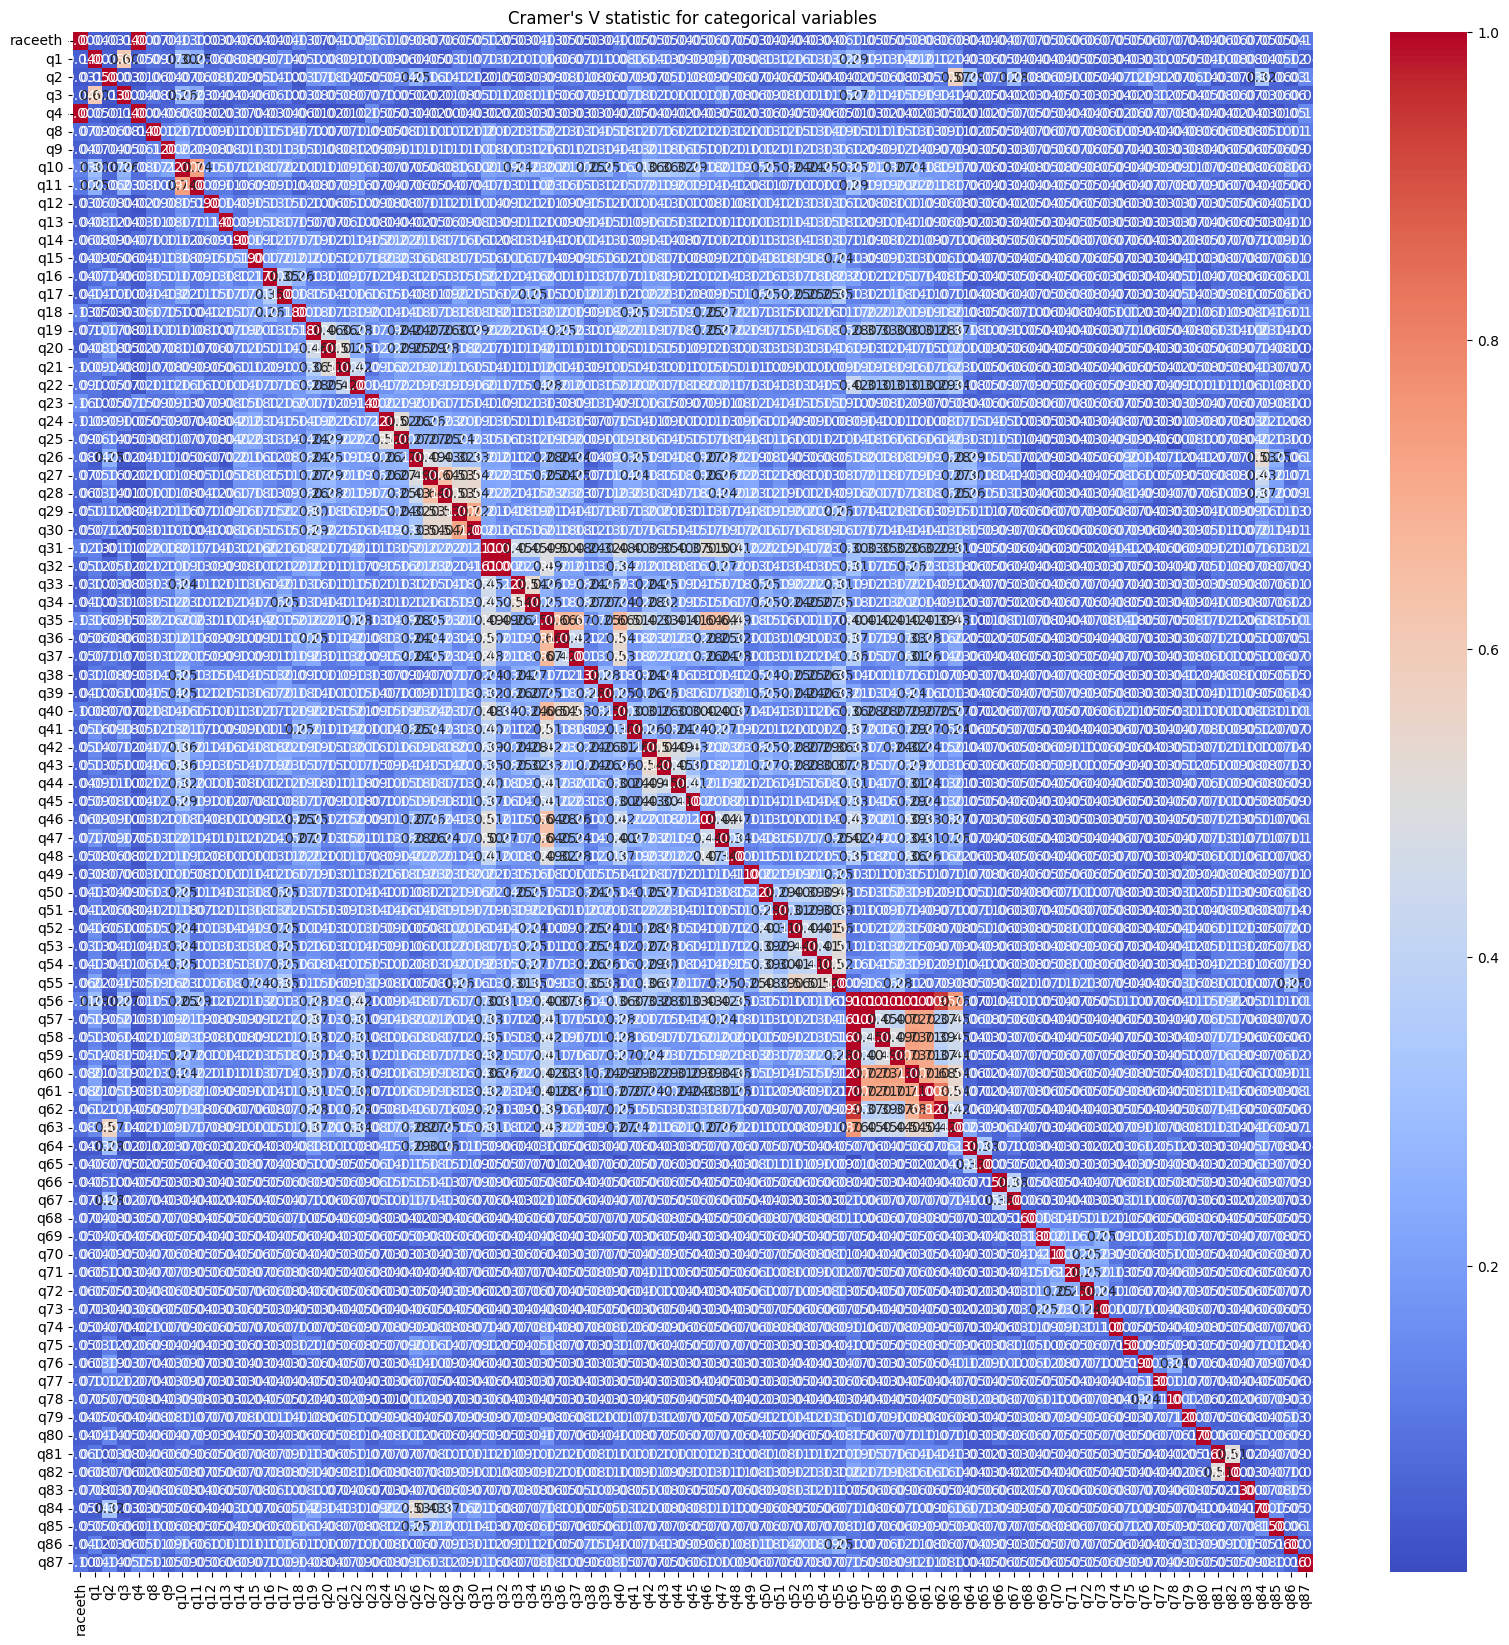

In [15]:
print(cramers_v_results)
# plot heatmap for the Cramer's V statistic
plt.figure(figsize=(20, 20))
sns.heatmap(cramers_v_results, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramer's V statistic for categorical variables")
plt.show()

In [16]:
# Convert Cramér's V matrix to a sorted list of variable pairs
cramers_v_pairs = (
    cramers_v_results
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Cramers V'})
)

# Remove duplicate pairs (keep only upper triangle of matrix)
cramers_v_pairs = cramers_v_pairs[cramers_v_pairs["Variable 1"] != cramers_v_pairs["Variable 2"]]

# Sort by Cramér's V in descending order
cramers_v_pairs = cramers_v_pairs.sort_values(by="Cramers V", ascending=False)

# Display sorted associations
print(cramers_v_pairs.head(30))

     Variable 1 Variable 2  Cramers V
4728        q58        q56   1.000000
4983        q61        q56   1.000000
4563        q56        q61   1.000000
4562        q56        q60   1.000000
4561        q56        q59   1.000000
4560        q56        q58   1.000000
2493        q32        q31   1.000000
340          q4    raceeth   1.000000
4898        q60        q56   1.000000
2409        q31        q32   1.000000
4813        q59        q56   1.000000
4       raceeth         q4   1.000000
4559        q56        q57   1.000000
4643        q57        q56   1.000000
5068        q62        q56   0.947679
4564        q56        q62   0.947679
5073        q62        q61   0.823033
4989        q61        q62   0.823033
4565        q56        q63   0.756632
5153        q63        q56   0.756632
603         q10        q11   0.735762
687         q11        q10   0.735762
4900        q60        q58   0.731473
4732        q58        q60   0.731473
4817        q59        q60   0.727589
4901        

In [17]:
# Convert Cramer's V matrix to a sorted list of variable pairs
cramers_v_pairs = (
    cramers_v_results
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Variable 1', 'level_1': 'Variable 2', 0: 'Cramers V'})
)

cramers_v_pairs["Pair"] = cramers_v_pairs.apply(lambda x: tuple(sorted([x["Variable 1"], x["Variable 2"]])), axis=1)

# Drop duplicate pairs (keep only unique combinations)
cramers_v_pairs = cramers_v_pairs.drop_duplicates(subset=["Pair"]).drop(columns=["Pair"])

# Remove self-correlations
cramers_v_pairs = cramers_v_pairs[cramers_v_pairs["Variable 1"] != cramers_v_pairs["Variable 2"]]

# Sort in descending order of Cramer's V
cramers_v_pairs = cramers_v_pairs.sort_values(by="Cramers V", ascending=False)

# Print the top 30 unique pairs
print(cramers_v_pairs.head(25))


     Variable 1 Variable 2  Cramers V
4561        q56        q59   1.000000
4       raceeth         q4   1.000000
4563        q56        q61   1.000000
2409        q31        q32   1.000000
4562        q56        q60   1.000000
4560        q56        q58   1.000000
4559        q56        q57   1.000000
4564        q56        q62   0.947679
4989        q61        q62   0.823033
4565        q56        q63   0.756632
603         q10        q11   0.735762
4732        q58        q60   0.731473
4817        q59        q60   0.727589
2237        q29        q30   0.721190
4648        q57        q61   0.717324
4647        q57        q60   0.715309
4903        q60        q61   0.714463
4733        q58        q61   0.713312
4818        q59        q61   0.710113
4904        q60        q62   0.677560
2754        q35        q37   0.667169
2753        q35        q36   0.664059
2757        q35        q40   0.658417
2065        q27        q28   0.644388
2763        q35        q46   0.637556


Highly correlated questions as above.\
Q61	Q62	0.823	Condom use during last sex vs. Birth control method used last time\
Q10	Q11	0.736	Riding with a drinking driver vs. Driving after drinking alcohol\
Q58	Q60	0.731	Number of sex partners vs. Alcohol/drug use before last sex\
Q59	Q60	0.728	Current sexual activity vs. Alcohol/drug use before last sex\
Q29	Q30	0.721	Suicide attempt vs. Suicide attempt requiring medical attention\
Q57	Q61	0.717	Age of first sexual intercourse vs. Condom use last time\
Q57	Q60	0.715	Age of first sex vs. Alcohol/drug use before last sex\
Q60	Q61	0.714	Alcohol/drug use before last sex vs. Condom use last time\
Q58	Q61	0.713	Number of sex partners vs. Condom use last time\
Q59	Q61	0.710	Current sexual activity vs. Condom use last time\
Q60	Q62	0.678	Alcohol/drug use before last sex vs. Birth control method used\
Q1	Q3	0.605	Age vs. Grade level\
Q2	Q63	0.567	Sex vs. Sex of sexual contacts\
Q52	Q55	0.560	Ever used cocaine vs. Ever injected an illegal drug\
Q60	Q63	0.540	Alcohol/drug use before last sex vs. Sex of sexual contacts\
Q42	Q43	0.539	Current alcohol use vs. Binge drinking\
Q36	Q40	0.539	Ever electronic vapor product use vs. Tried quitting all tobacco products\
Q33	Q34	0.537	Current cigarette use vs. Heavy cigarette smoking (>10 per day)\
Q61	Q63	0.536	Condom use vs. Sex of sexual contacts\
Q37	Q40	0.533	Current electronic vapor product use vs. Tried quitting all tobacco products\
Q54	Q55	0.516	Ever used ecstasy vs. Ever injected an illegal drug\
Q53	Q55	0.514	Ever used methamphetamine vs. Ever injected an illegal drug\
Q81	Q82	0.513	Ever tested for HIV vs. Ever tested for STDs\
Q20	Q21	0.511	Forced sexual intercourse vs. Dating sexual violence\
Q58	Q59	0.492	Number of sex partners vs. Current sexual activity\


Strong association is seen among sexual behaviors and risky practices. Q57 (Age at first sex), Q58 (Number of sex partners), Q59 (Current sexual activity), Q60 (Alcohol/drug use before last sex), Q61 (Condom use), and Q62 (Birth control method used) are highly interrelated. One possible explanation is that individuals with earlier sexual debut (Q57) tend to have more partners (Q58) and are more likely to engage in risky behaviors like substance use before sex (Q60) and not using protection (Q61, Q62). To account for these correlations, we are combining several question reponses to new binary indicators of risky sexual behaviors. This will also help reduce the dimensionality. \
q34, q40, q43 and q44 is dropped because of largely missing values and not meaningful implications.

In [18]:
# A few extra feature engineering to account for collinearity.
# Comment out the ones you wish not to create
df["q10_11_unsafe_driving"] = ((df["q10"] > 1) | (df["q11"] > 1)).astype(int)
df["q27_30_suicide_combined"] = ((df["q30"]) != 0 | (df["q29"] != 0) | (df["q28"] != 0) | (df["q27"] != 0)).astype(int)
df["q33_smoking"] = (df["q33"] != 0).astype(int)
df["q48_55_substance_use"] = (df.loc[:, "q48":"q55"] != 0).any(axis=1).astype(int) # q48 to 55 combined as substance_use indicator
df["q57_early_sexual_intercourse"] = (df["q57"] != 0).astype(int) # first sexual intercourse age question transoformed to binary variable maerked as 1 if q57 response is not 0 (never had sex)
df["q60_62_unsafe_sex"] = ((df["q60"] == 0) | (df["q61"] == 0) | (df["q62"].isin([0, 5]))).astype(int) # as long as one of the related question matches, this variable will be 1
df["q68_73_healthy_diet"] = (df.loc[:, "q68":"q73"].ne(0).sum(axis=1) >= 3).astype(int) # healthy_diet = 1 if at least 3 of q68-73 are not 0
df["q81_82_std_checked"] = ((df["q81"] == 1) | (df["q82"] == 1)).astype(int)
df["suicide_attempt"] = (df["q29"] != 0).astype(int)


In [19]:
## storing possible target variable, choose as you wish. Raw questions are not one hot encoded yet.
q27_raw = df["q27"]
q28_raw = df["q28"]
q29_raw = df["q29"]
q30_raw = df["q30"]
suicide_q29_attempt = df["suicide_attempt"]
suicide_combined_q = df["q27_30_suicide_combined"]

In [20]:
df = df.drop(columns=["q10", "q11", "q27", "q28", "q29", "q30", "q33", "q48", "q49", "q50", "q51", "q52", "q53", "q54",
                      "q55", "q60", "q61", "q62", "q68", "q69", "q70", "q71", "q72", "q73", "q81", "q82", "suicide_combined", "psu", "stratum", "record"],
                      errors='ignore'
                      )

In [21]:
# renaming for clarity, add more if you would like to.
df = df.rename(columns={'q1': 'q1_age',
                        'q2': 'q2_gender',
                        'q3': 'q3_grade',
                        'q4': 'q4_ethnicity',
                        'q5': 'q5_race',
                        'q6': 'q6_height',
                        'q7': 'q7_weight',
                        'q8': 'q8_seatbelt_riding',
                        'q9': 'q9_ride_w_drunk_drinver',
                        'q12': 'q12_days_carrying_weapon_atschool',
                        'q13': 'q13_days_carrying_gun',
                        'q14': 'q14_skipped_school_bc_insecure',
                        'q15': 'q15_been_threatened_at_school',
                        'q16': 'q16_12mo_physical_fight',
                        'q17': 'q17_12mo_physicalf_school',
                        'q18': 'q18_seen_vio_neighborhood',
                        'q19': 'q19_forced_sex',
                        'q20': 'q20_forced_sexual',
                        'q21': 'q21_dating_unwilling_sexual',
                        'q22': 'q22_dating_physical_hurting',
                        'q23': 'q23_discriminated',
                        'q24': 'q24_been_bullied',
                        'q25': 'q25_electronically_bullied',
                        'q26': 'q26_depression',
                        'q31': 'q31_ever_smoked',
                        'q32': 'q32_first_smoke_age',
                        'q34': 'q34_smoke_count_daily',
                        'q35': 'q35_ever_vaped',
                        'q36': 'q36_days_vaped_30d',
                        'q37': 'q37_vapor_source',
                        'q38': 'q38_days_chewed_30d',
                        'q39': 'q39_days_smoked_30d',
                        'q40': 'q40_quit_tabacco_12mo',
                        'q41': 'q41_first_drink_age',
                        'q42': 'q42_days_drank_30d',
                        'q43': 'q43_days_binge_drink_30d',
                        'q44': 'q44_max_drinks_30d',
                        'q45': 'q45_alcohol_source',
                        'q46': 'q46_times_marijuana',
                        'q47': 'q47_first_marijuana_age',
                        'q56': 'q56_early_sex',
                        'q57': 'q57_age_first_sex',
                        'q58': 'q58_sexual_partners_count',
                        'q59': 'q59_sex_count_3mo',
                        'q63': 'q63_sex_contact_gender',
                        'q64': 'q64_sexual_identity',
                        'q65': 'q65_transgender',
                        'q66': 'q66_weight_perception',
                        'q67': 'q67_weight_plans',
                        'q74': 'q74_soda_count',
                        'q75': 'q75_days_breakfast_1w',
                        'q76': 'q76_days_physically_active_1w',
                        'q77': 'q77_days_PE_class_1w',
                        'q78': 'q78_sports_team_count_12mo',
                        'q79': 'q79_concussion_count_12mo',
                        'q80': 'q80_social_media_freq',
                        'q83': 'q83_last_dentist',
                        'q84': 'q84_mental_health_not_good',
                        'q85': 'q85_workdays_average_sleep',
                        'q86': 'q86_unstable_housing',
                        'q87': 'q87_academic_grades'
                        }
                        )

In [22]:
df = df.drop(columns=['q4_ethnicity', 'q5_race'],
                      errors='ignore'
                      )

ONE LAST THING
\
Depending on how you want to impute the missing data, either dropping the not important columns or impute with decision trees. I will leave that to you.

In [23]:
# missing values
missing_counts_df = df.isnull().sum()
missing_percent_df = df.isnull().mean()
missing_df = pd.DataFrame({'missing_counts': missing_counts_df,
                              'missing_percent': missing_percent_df}).sort_values(
    by='missing_percent', ascending=False)
missing_df[missing_df['missing_percent'] > 0]

,missing_counts,missing_percent
q13_days_carrying_gun,8729,0.434214
q16_12mo_physical_fight,8451,0.420385
q66_weight_perception,8308,0.413272
q34_smoke_count_daily,7946,0.395264
q78_sports_team_count_12mo,7139,0.355121
...,...,...
q25_electronically_bullied,205,0.010197
q24_been_bullied,201,0.009999
q3_grade,193,0.009601
q2_gender,158,0.007860


impute missing values using decision tree regressor.

In [24]:
# impute missing values using decision tree regressor
# get the columns with missing values greater than 0
cols = missing_df[missing_df['missing_percent'] > 0].index.tolist()

for col in cols:
    print(f"Imputing missing values for column: {col}")
    df_hidden = df.copy()
    # impute missing values with Mode for columns other than 'col' in test_data
    for s in df.columns.difference([col]):
        df_hidden.loc[:, s] = df_hidden[s].fillna(df[s].mode()[0])

    # Split the data into train and test sets
    train_data = df_hidden.dropna()
    test_data = df_hidden[df_hidden[col].isnull()]

    X_train = train_data.drop(columns=[col])
    y_train = train_data[col]
    X_test = test_data.drop(columns=[col])
    y_test = test_data[col]
    # Train a decision tree regressor
    tree = DecisionTreeRegressor()
    tree.fit(X_train, y_train)
    # Predict the missing values
    y_pred = tree.predict(X_test)
    # Fill in the missing values
    df.loc[df[col].isnull(), col] = y_pred

Imputing missing values for column: q13_days_carrying_gun
Imputing missing values for column: q16_12mo_physical_fight
Imputing missing values for column: q66_weight_perception
Imputing missing values for column: q34_smoke_count_daily
Imputing missing values for column: q78_sports_team_count_12mo
Imputing missing values for column: q77_days_PE_class_1w
Imputing missing values for column: q37_vapor_source
Imputing missing values for column: q67_weight_plans
Imputing missing values for column: q75_days_breakfast_1w
Imputing missing values for column: q45_alcohol_source
Imputing missing values for column: q44_max_drinks_30d
Imputing missing values for column: q86_unstable_housing
Imputing missing values for column: q18_seen_vio_neighborhood
Imputing missing values for column: q8_seatbelt_riding
Imputing missing values for column: q74_soda_count
Imputing missing values for column: q80_social_media_freq
Imputing missing values for column: q40_quit_tabacco_12mo
Imputing missing values for col

down sampling

In [25]:
class_counts = df["suicide_attempt"].value_counts()
print("Before balancing:", class_counts)


min_class_size = class_counts.min()

# down sampling
balanced_df = df.groupby("suicide_attempt", group_keys=False).apply(lambda x: x.sample(min_class_size, random_state=42))

print("After balancing:", balanced_df["suicide_attempt"].value_counts())
balanced_df.to_csv("/content/drive/MyDrive/yrbss/balanced_dataset.csv", index=False)

Before balancing: suicide_attempt
0    17341
1     2762
Name: count, dtype: int64
After balancing: suicide_attempt
0    2762
1    2762
Name: count, dtype: int64


<ipython-input-25-69847f7d61a8>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby("suicide_attempt", group_keys=False).apply(lambda x: x.sample(min_class_size, random_state=42))


In [26]:
balanced_df.columns[:50]

Index(['raceeth', 'q1_age', 'q2_gender', 'q3_grade', 'q6_height', 'q7_weight',
       'q8_seatbelt_riding', 'q9_ride_w_drunk_drinver',
       'q12_days_carrying_weapon_atschool', 'q13_days_carrying_gun',
       'q14_skipped_school_bc_insecure', 'q15_been_threatened_at_school',
       'q16_12mo_physical_fight', 'q17_12mo_physicalf_school',
       'q18_seen_vio_neighborhood', 'q19_forced_sex', 'q20_forced_sexual',
       'q21_dating_unwilling_sexual', 'q22_dating_physical_hurting',
       'q23_discriminated', 'q24_been_bullied', 'q25_electronically_bullied',
       'q26_depression', 'q31_ever_smoked', 'q32_first_smoke_age',
       'q34_smoke_count_daily', 'q35_ever_vaped', 'q36_days_vaped_30d',
       'q37_vapor_source', 'q38_days_chewed_30d', 'q39_days_smoked_30d',
       'q40_quit_tabacco_12mo', 'q41_first_drink_age', 'q42_days_drank_30d',
       'q43_days_binge_drink_30d', 'q44_max_drinks_30d', 'q45_alcohol_source',
       'q46_times_marijuana', 'q47_first_marijuana_age', 'q56_early_s

In [27]:
balanced_df.columns[50:100]

Index(['q76_days_physically_active_1w', 'q77_days_PE_class_1w',
       'q78_sports_team_count_12mo', 'q79_concussion_count_12mo',
       'q80_social_media_freq', 'q83_last_dentist',
       'q84_mental_health_not_good', 'q85_workdays_average_sleep',
       'q86_unstable_housing', 'q87_academic_grades', 'BMIPCT', 'weight',
       'q10_11_unsafe_driving', 'q27_30_suicide_combined', 'q33_smoking',
       'q48_55_substance_use', 'q57_early_sexual_intercourse',
       'q60_62_unsafe_sex', 'q68_73_healthy_diet', 'q81_82_std_checked',
       'suicide_attempt'],
      dtype='object')

In [34]:
# feature selection
columns=['q14_skipped_school_bc_insecure', 'q15_been_threatened_at_school', 'q16_12mo_physical_fight', 'q18_seen_vio_neighborhood', 'q19_forced_sex', 'q21_dating_unwilling_sexual', 'q22_dating_physical_hurting', 'q23_discriminated','q24_been_bullied', 'q26_depression', 'q32_first_smoke_age', 'q34_smoke_count_daily', 'q35_ever_vaped', 'q42_days_drank_30d', 'q47_first_marijuana_age','q57_age_first_sex', 'q66_weight_perception', 'q86_unstable_housing', 'BMIPCT', 'suicide_attempt']
regression_df = balanced_df[columns]
# one-hot-encoding categorical variables where needed.
# List of categorical variables to one-hot encode
one_hot_vars = ['q14_skipped_school_bc_insecure', 'q15_been_threatened_at_school', 'q16_12mo_physical_fight', 'q18_seen_vio_neighborhood', 'q19_forced_sex', 'q21_dating_unwilling_sexual', 'q22_dating_physical_hurting', 'q23_discriminated','q24_been_bullied', 'q26_depression', 'q32_first_smoke_age', 'q34_smoke_count_daily', 'q35_ever_vaped', 'q42_days_drank_30d', 'q47_first_marijuana_age','q57_age_first_sex', 'q66_weight_perception', 'q86_unstable_housing']

# Perform one-hot encoding
regression_df = pd.get_dummies(regression_df, columns=one_hot_vars, dtype=int)

In [35]:
regression_df.to_csv("/content/drive/MyDrive/yrbss/regression_df.csv", index=False)


